<a href="https://colab.research.google.com/github/TrongNgoVan/App_SystemManageEmployee/blob/master/LSTM_Predict_Sales_by_Ng%E1%BB%8D_V%C4%83n_Tr%E1%BB%8Dng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision  # Cài đặt PyTorch và các gói liên quan
!pip install scikit-learn  # Cài đặt scikit-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install openpyxl


In [ ]:
!pip install prophet


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Đường dẫn đến file CSV
file_path = '/content/PreprocessingData.csv'

# Đọc file CSV
df = pd.read_csv(file_path)
# Loại bỏ khoảng trắng ở đầu và cuối tên cột
df.columns = df.columns.str.strip()
# Bỏ cột không cần thiết
df = df.drop(columns=['Unnamed: 0'])

# Chuyển đổi cột 'Ngày:' thành kiểu datetime (nếu cần)
df['Ngày:'] = pd.to_datetime(df['Ngày:'])

# Chọn các cột dữ liệu số
df_data = df.iloc[:, 1:]  # Bỏ cột 'Ngày:', chỉ giữ lại các cột dữ liệu số

# Chuyển đổi tất cả các cột thành kiểu số (nếu cần)
df_data = df_data.apply(pd.to_numeric, errors='coerce')

# Xử lý giá trị NaN: Thay thế NaN bằng giá trị trung bình
df_data = df_data.fillna(df_data.mean())

# Kiểm tra lại dữ liệu sau khi chuyển đổi
print(df_data.head())
print("Số lượng giá trị NaN còn lại trong mỗi cột:\n", df_data.isnull().sum())

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df_data)  # Chuẩn hóa các cột dữ liệu

# Tạo tập dữ liệu với nhiều biến đầu vào
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Lấy tất cả các cột
        y.append(data[i + time_step, :])  # Dự đoán tất cả các cột
    return np.array(X), np.array(y)

# Số bước thời gian của chuỗi
time_step = 10  # Có thể điều chỉnh nếu cần
X, y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Giữ nguyên số lượng cột

# Tạo mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Số cột output có thể khác với số cột input

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Lấy đầu ra của bước cuối cùng
        return out

# Khởi tạo mô hình, loss và optimizer
input_size = X.shape[2]  # Số lượng cột đầu vào
output_size = X.shape[2]  # Dự đoán tất cả các cột
model = LSTMModel(input_size=input_size, output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(torch.FloatTensor(X_train))
    loss = criterion(outputs, torch.FloatTensor(y_train))
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Dự đoán cho tập kiểm tra
model.eval()
test_predict = model(torch.FloatTensor(X_test)).detach().numpy()

# Dự đoán 3 ngày tiếp theo (dựa trên dữ liệu cuối cùng trong tập test)
input_data = X_test[-1].reshape(1, time_step, input_size)  # Dữ liệu cuối cùng trong tập test
predictions = []
for _ in range(3):  # Dự đoán cho 3 ngày tiếp theo
    pred = model(torch.FloatTensor(input_data)).detach().numpy()
    predictions.append(pred)
    # Cập nhật input_data với dự đoán mới
    input_data = np.append(input_data[:, 1:, :], pred.reshape(1, 1, input_size), axis=1)

# Chuyển predictions thành numpy array và ngược lại thang đo gốc
predictions = np.array(predictions).reshape(3, output_size)  # 3 ngày, số lượng cột bằng với output
predictions_original_scale = scaler.inverse_transform(predictions)

# In dự đoán đã được chuyển đổi về thang đo gốc
print("Dự đoán cho 3 ngày tiếp theo (giá trị gốc): ", predictions_original_scale)


   Doanh thu Affilicate (nghìn đồng)  Doanh thu cửa hàng (nghìn đồng)  \
0                          1410000.0                          1940.00   
1                          1470000.0                          6770.00   
2                          1340000.0                          3130.00   
3                          1790000.0                           829.85   
4                          1610000.0                             0.00   

   Đơn giá bình quân (nghìn đồng)  Lượt bán (nghìn lượt)  \
0                          118.91                  12.35   
1                          119.14                  13.32   
2                          104.27                  13.50   
3                          117.69                  15.97   
4                          114.85                  14.81   

   Doanh thu tài khoản tự vận hành (nghìn đồng)  
0                                       10440.0  
1                                       12500.0  
2                                       13060.0  


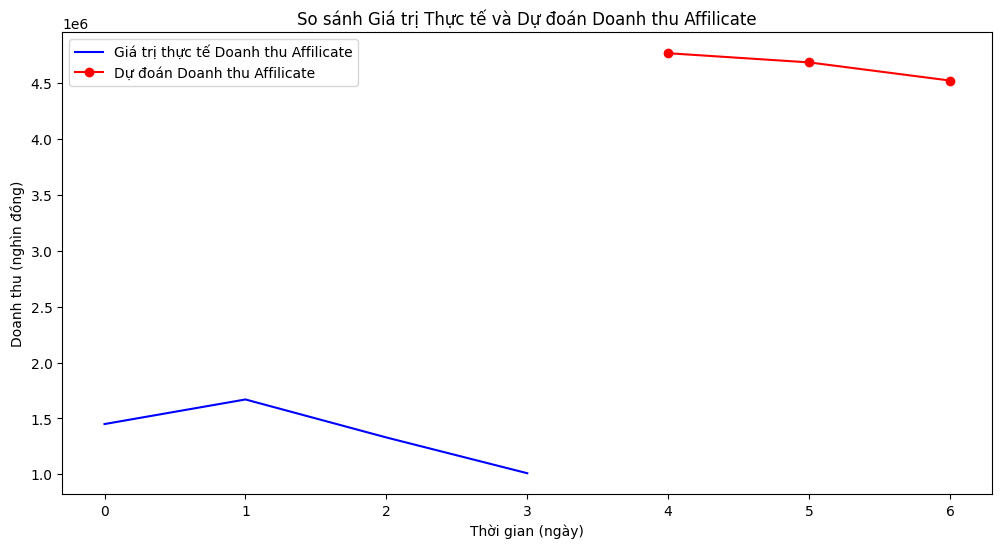

In [ ]:
import matplotlib.pyplot as plt

# Giả sử y_test là dữ liệu thực tế của bạn
# Chuyển đổi y_test về thang đo gốc
y_test_original_scale = scaler.inverse_transform(y_test)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(y_test_original_scale[:, 0], label='Giá trị thực tế Doanh thu Affilicate', color='blue')
plt.plot(range(len(y_test_original_scale), len(y_test_original_scale) + 3), predictions_original_scale[:, 0], label='Dự đoán Doanh thu Affilicate', color='red', marker='o')
plt.title('So sánh Giá trị Thực tế và Dự đoán Doanh thu Affilicate')
plt.xlabel('Thời gian (ngày)')
plt.ylabel('Doanh thu (nghìn đồng)')
plt.legend()
plt.show()
